**1. Read and import data**

In [30]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
dataset = pd.read_csv('./data/salary.csv', sep='|')

In [3]:
dataset.head(2)

,id,job_title,location,salary_currency,career_level,experience_level,education_level,employment_type,job_function,job_benefits,company_process_time,company_size,company_industry,job_description,salary
0,1,Facility Maintenance & Smart Warehouse Manager,Bandung,IDR,Manajer/Asisten Manajer,5 tahun,"Sertifikat Professional, D3 (Diploma), D4 (Dip...",Penuh Waktu,"Manufaktur,Pemeliharaan",NaN,NaN,NaN,NaN,Deskripsi PekerjaanRequirements :D3/SI from re...,NaN
1,2,Procurement Department Head,Jakarta Raya,IDR,Manajer/Asisten Manajer,5 tahun,"Sarjana (S1), Diploma Pascasarjana, Gelar Prof...",Penuh Waktu,"Manufaktur,Pembelian/Manajemen Material",NaN,25 days,51 - 200 pekerja,Manajemen/Konsulting HR,Job Role: 1. Responsible for material availabi...,NaN


**2. Cleaning the data**

In [4]:
# Size grafik
sns.set(rc={'figure.figsize':(10, 5)})

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34746 entries, 0 to 34745
Data columns (total 15 columns):
id                      34746 non-null int64
job_title               34746 non-null object
location                34746 non-null object
salary_currency         34742 non-null object
career_level            34746 non-null object
experience_level        30205 non-null object
education_level         34746 non-null object
employment_type         33402 non-null object
job_function            34746 non-null object
job_benefits            27330 non-null object
company_process_time    24555 non-null object
company_size            29103 non-null object
company_industry        33132 non-null object
job_description         34745 non-null object
salary                  9352 non-null float64
dtypes: float64(1), int64(1), object(13)
memory usage: 4.0+ MB


In [6]:
# Check null values
dataset.isnull().sum()

id                          0
job_title                   0
location                    0
salary_currency             4
career_level                0
experience_level         4541
education_level             0
employment_type          1344
job_function                0
job_benefits             7416
company_process_time    10191
company_size             5643
company_industry         1614
job_description             1
salary                  25394
dtype: int64

In [7]:
# Remove Column 
dataset = dataset.drop(labels=["id", "salary_currency", "job_benefits", "job_function", "job_description",
"company_process_time", "company_size", "company_industry", "employment_type"], axis=1)

Cleaning Salary

In [8]:
# Mengisi data salary yang nan atau null dengan median
dataset['salary'].fillna(dataset.groupby(["experience_level"])['salary'].transform('median'), inplace=True)
dataset['salary'] = dataset['salary'].round(0)

Cleaning Experience Level

In [9]:
# Convert experience_level str => float
dataset["experience_level"] = dataset["experience_level"].str.replace("\D", "").fillna(0).astype('float')

# Mengisi data experience_level yang 0 dengan median
dataset['experience_level'].replace(to_replace=0, value=dataset.groupby(["salary"])['experience_level'].transform('median'), inplace=True)

Outlier

In [10]:
dataset.dropna(inplace=True)

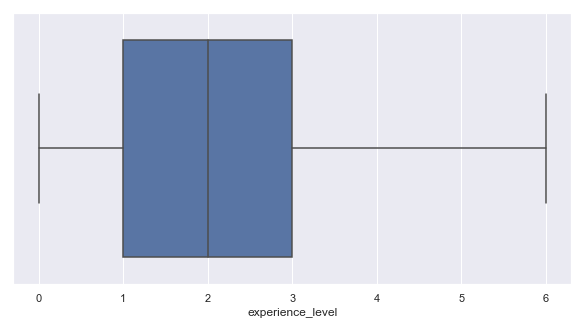

In [11]:
# Experience
per25Exp = dataset['experience_level'].quantile(0.25)
per75Exp = dataset['experience_level'].quantile(0.75)
iqrExp = per75Exp - per25Exp

lower_limit = per25Exp - 1.5 * iqrExp
upper_limit = per75Exp + 1.5 * iqrExp

dataset = dataset[~((dataset["experience_level"] < (lower_limit)) | (dataset["experience_level"] > (upper_limit)))]

sns.boxplot(dataset["experience_level"])
plt.show()

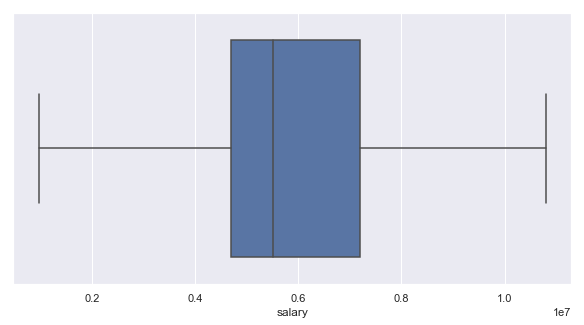

In [12]:
# Salary
per25Salary = dataset['salary'].quantile(0.25)
per75Salary = dataset['salary'].quantile(0.75)
iqrSalary = per75Salary - per25Salary

lower_limit = per25Salary - 1.5 * iqrSalary
upper_limit = per75Salary + 1.5 * iqrSalary

dataset = dataset[~((dataset["salary"] < (lower_limit)) | (dataset["salary"] > (upper_limit)))]

sns.boxplot(dataset["salary"])
plt.show()

Result Cleaning

In [13]:
dataset.shape

(28607, 6)

In [14]:
# Check null values
dataset.isnull().sum()

job_title           0
location            0
career_level        0
experience_level    0
education_level     0
salary              0
dtype: int64

In [15]:
dataset.reset_index(drop=True, inplace=True)
dataset.head(5)

,job_title,location,career_level,experience_level,education_level,salary
0,Facility Maintenance & Smart Warehouse Manager,Bandung,Manajer/Asisten Manajer,5.0,"Sertifikat Professional, D3 (Diploma), D4 (Dip...",10500000.0
1,Procurement Department Head,Jakarta Raya,Manajer/Asisten Manajer,5.0,"Sarjana (S1), Diploma Pascasarjana, Gelar Prof...",10500000.0
2,SALES ADMIN,Jakarta Barat,Supervisor/Koordinator,4.0,Sarjana (S1),8450000.0
3,City Operation Lead Shopee Express (Cirebon),Cirebon,Supervisor/Koordinator,5.0,"Sarjana (S1), Diploma Pascasarjana, Gelar Prof...",10500000.0
4,Japanese Interpreter,Bekasi,Pegawai (non-manajemen & non-supervisor),2.0,"Sertifikat Professional, D3 (Diploma), D4 (Dip...",5500000.0


In [16]:
dataset.describe()

,experience_level,salary
count,28607.000000,2.860700e+04
mean,2.141084,5.980619e+06
std,1.251596,1.923043e+06
min,0.000000,9.600000e+05
25%,1.000000,4.700000e+06
50%,2.000000,5.500000e+06
75%,3.000000,7.200000e+06
max,6.000000,1.080000e+07


**3. Discovering the data**

Kind of Experience Level

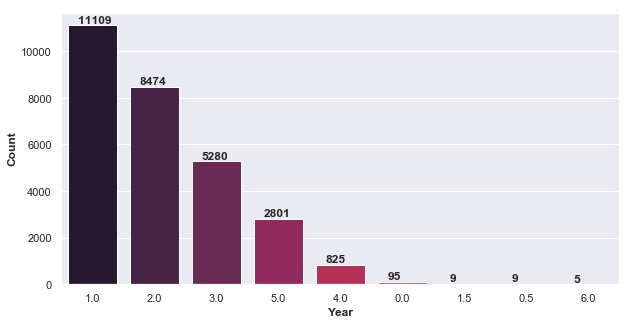

In [17]:
countEXP = sns.load_dataset("tips")
barExp = sns.countplot(data = countEXP, x = dataset["experience_level"], palette="rocket", order = dataset["experience_level"].value_counts().index)
plt.ylabel("Count", fontweight='bold')
plt.xlabel("Year", fontweight='bold')

for p, label in zip(barExp.patches, dataset["experience_level"].value_counts()):
    barExp.annotate(label, (p.get_x() + 1/6, p.get_height() + 100), fontweight='bold')
    
plt.show()

Average Salary based on Experience Level

In [18]:
dataset.groupby(by="experience_level")["salary"].mean().round(0).nlargest(10) 

experience_level
5.0    10019746.0
4.0     8198712.0
6.0     7890000.0
3.0     7027532.0
1.5     5516667.0
2.0     5514822.0
1.0     4679527.0
0.0     3352857.0
0.5     3097778.0
Name: salary, dtype: float64

**4. Predict the salary**

In [19]:
X = pd.DataFrame(dataset, columns=["location", "career_level", "experience_level", "education_level"])
Y = pd.DataFrame(dataset, columns=["salary"])

Metode OLS

In [53]:
model1 = smf.ols("salary~location", data=dataset).fit()
print(model1.summary())
print("\n")

yPred1 = model1.predict(X)
print("Prekdiksi Salary vs Location", yPred1.head(5))
print("\n")
print("MSE Salary vs Location",  mean_squared_error(Y, yPred1))

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     8.199
Date:                Tue, 06 Jun 2023   Prob (F-statistic):          2.35e-208
Time:                        15:30:29   Log-Likelihood:            -4.5375e+05
No. Observations:               28607   AIC:                         9.079e+05
Df Residuals:                   28414   BIC:                         9.095e+05
Df Model:                         192                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [21]:
model2 = smf.ols("salary~career_level", data=dataset).fit()
print(model2.summary())
print("\n")

yPred2 = model2.predict(X)
print("Prekdiksi Salary vs Career", yPred2.head(5))
print("\n")
print("MSE Salary vs Career",  mean_squared_error(Y, yPred2))

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     2819.
Date:                Tue, 06 Jun 2023   Prob (F-statistic):               0.00
Time:                        14:32:45   Log-Likelihood:            -4.4976e+05
No. Observations:               28607   AIC:                         8.995e+05
Df Residuals:                   28602   BIC:                         8.996e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [22]:
model3 = smf.ols("salary~experience_level", data=dataset).fit()
print(model3.summary())
print("\n")

yPred3 = model3.predict(X)
print("Prekdiksi Salary vs Experience", yPred3.head(5))
print("\n")
print("MSE Salary vs Experience",  mean_squared_error(Y, yPred3))

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                 7.126e+04
Date:                Tue, 06 Jun 2023   Prob (F-statistic):               0.00
Time:                        14:32:46   Log-Likelihood:            -4.3663e+05
No. Observations:               28607   AIC:                         8.733e+05
Df Residuals:                   28605   BIC:                         8.733e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         3.202e+06   1.21e+04  

In [23]:
model4 = smf.ols("salary~education_level", data=dataset).fit()
print(model4.summary())
print("\n")

yPred4 = model4.predict(X)
print("Prekdiksi Salary vs Education", yPred4.head(5))
print("\n")
print("MSE Salary vs Education",  mean_squared_error(Y, yPred4))

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     203.6
Date:                Tue, 06 Jun 2023   Prob (F-statistic):               0.00
Time:                        14:32:46   Log-Likelihood:            -4.5270e+05
No. Observations:               28607   AIC:                         9.054e+05
Df Residuals:                   28587   BIC:                         9.056e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                                                                                                                                        coef    std err          t      P>|t|      [0.025      0.9

Metode Pendekatan Bayesian Regresi Linear

In [61]:
modelGLS = smf.glm("salary~experience_level", data=dataset).fit()
print(modelGLS.summary())
print("\n")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 salary   No. Observations:                28607
Model:                            GLM   Df Residuals:                    28605
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      1.0593e+12
Method:                          IRLS   Log-Likelihood:            -4.3663e+05
Date:                Tue, 06 Jun 2023   Deviance:                   3.0301e+16
Time:                        16:06:11   Pearson chi2:                 3.03e+16
No. Iterations:                     3   Covariance Type:             nonrobust
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         3.202e+06   1.21e+04    265.525      0.000    3.18e+06    3.23e+06
experience_level  1.298e+06   4861

Visualisasi Data Prediksi

In [24]:
xYear = dataset.loc[:, ["experience_level"]].values
ySalary = dataset.loc[:, ["salary"]].values

xTrain, xTest, yTrain, yTest = train_test_split(xYear, ySalary, test_size = 0.3, random_state = 0)
predictExpSal = LinearRegression()
predictExpSal.fit(xTrain, yTrain)

print("Data Training Set", xTrain.shape)
print("Data Test Set", xTest.shape)

Data Training Set (20024, 1)
Data Test Set (8583, 1)


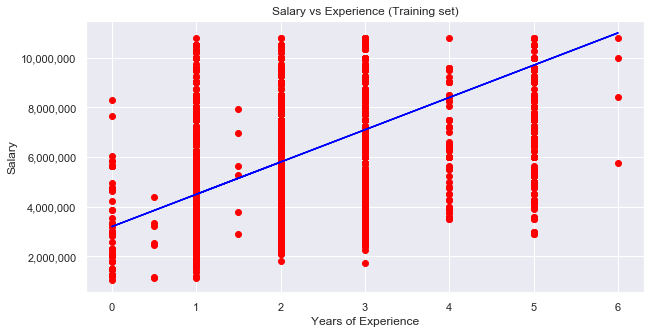

In [25]:
plt.scatter(xTrain, yTrain, color = 'red')
plt.plot(xTrain, predictExpSal.predict(xTrain), color = 'blue')
plt.title('Salary vs Experience (Training set)')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')

formatSal = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(i) for i in formatSal])

plt.show()

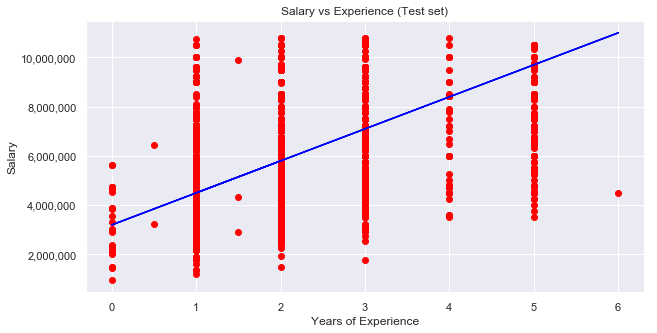

In [26]:
plt.scatter(xTest, yTest, color = 'red')
plt.plot(xTrain, predictExpSal.predict(xTrain), color = 'blue')
plt.title('Salary vs Experience (Test set)')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')

plt.gca().set_yticklabels(['{:,.0f}'.format(i) for i in formatSal])

plt.show()

In [27]:
# Memprediksi gaji berdasarkan experience 
# model.predict(year)
predictExpSal.predict([[10]])

array([[16198407.66655117]])

In [28]:
# Keakuratan model data
predictExpSal.score(xTest, yTest)

0.7155417503389994